## ASSIGNMENT OVERVIEW

This assignment implements and compares two CNN approaches:
1. **Custom CNN** architecture using PyTorch
2. **Transfer Learning** using pre-trained ResNet18

### Key Requirements:
- Framework: **PyTorch**
- Dataset: **Cats vs Dogs** (2000 images per class)
- **Global Average Pooling (GAP)** is MANDATORY for both models
- DO NOT use Flatten + Dense layers
- Primary Metric: **Accuracy**

In [1]:
# Install Required Packages
# Run this cell first if packages are not already installed

import sys
import subprocess

def install_package(package):
    """Install a package using pip"""
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package, "-q"])
        print(f"✓ {package} installed successfully")
    except Exception as e:
        print(f"✗ Failed to install {package}: {str(e)}")

# List of required packages
required_packages = [
    'numpy',
    'pandas',
    'matplotlib',
    'seaborn',
    'scikit-learn',
    'torch',
    'torchvision',
    'Pillow',
    'tqdm',
    'kagglehub'
]

print("="*70)
print("INSTALLING REQUIRED PACKAGES")
print("="*70)
print("\nThis may take a few minutes...\n")

for package in required_packages:
    install_package(package)

print("\n" + "="*70)
print("PACKAGE INSTALLATION COMPLETE")
print("="*70)
print("\nNote: For PyTorch with CUDA support, visit: https://pytorch.org/")
print("Current installation uses CPU-only version.")
print("="*70)

INSTALLING REQUIRED PACKAGES

This may take a few minutes...

✓ numpy installed successfully
✓ pandas installed successfully
✓ matplotlib installed successfully
✓ seaborn installed successfully
✓ scikit-learn installed successfully
✓ torch installed successfully
✓ torchvision installed successfully
✓ Pillow installed successfully
✓ tqdm installed successfully
✓ kagglehub installed successfully

PACKAGE INSTALLATION COMPLETE

Note: For PyTorch with CUDA support, visit: https://pytorch.org/
Current installation uses CPU-only version.


In [2]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import time
import json
import os
import shutil
from pathlib import Path
from tqdm import tqdm

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms, models

# Image processing
from PIL import Image

# Kaggle dataset download
import kagglehub

print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")
print(f"Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

PyTorch version: 2.10.0+cpu
Torchvision version: 0.25.0+cpu
Device: CPU


## PART 1: DATASET LOADING AND EXPLORATION

In [3]:
# 1.1 Download Cats vs Dogs Dataset using Kagglehub
print("="*70)
print("DOWNLOADING CATS VS DOGS DATASET")
print("="*70)

# Check if dataset already exists locally
cache_dir = Path.home() / '.cache' / 'kagglehub' / 'datasets' / 'shaunthesheep' / 'microsoft-catsvsdogs-dataset'
dataset_exists = cache_dir.exists() and any(cache_dir.glob('*/PetImages'))

if dataset_exists:
    print("Dataset already exists locally, skipping download...")
    dataset_path = str(cache_dir / 'versions' / '1')  # Adjust version if needed
    # Try to find the actual path
    for version_path in cache_dir.glob('versions/*'):
        if (version_path / 'PetImages').exists() or any(version_path.glob('*/PetImages')):
            dataset_path = str(version_path)
            break
else:
    print("Downloading dataset (will be cached for future runs)...")
    # Download dataset
    dataset_path = kagglehub.dataset_download('shaunthesheep/microsoft-catsvsdogs-dataset')
    print(f"Dataset downloaded to: {dataset_path}")

# Locate the PetImages folder
petimages_path = Path(dataset_path) / 'PetImages'
if not petimages_path.exists():
    petimages_path = Path(dataset_path) / 'microsoft-catsvsdogs-dataset' / 'PetImages'

print(f"PetImages path: {petimages_path}")
print("="*70)

DOWNLOADING CATS VS DOGS DATASET


100%|██████████| 788M/788M [01:16<00:00, 10.9MB/s] 

Extracting files...


Dataset downloaded to: C:\Users\debas\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1
PetImages path: C:\Users\debas\.cache\kagglehub\datasets\shaunthesheep\microsoft-catsvsdogs-dataset\versions\1\PetImages


In [4]:
# 1.2 Prepare Dataset: Select 2000 images per class and organize
print("\n" + "="*70)
print("PREPARING DATASET (2000 images per class)")
print("="*70)

# Create organized dataset directory
output_dir = Path('cats_dogs_dataset')
train_dir = output_dir / 'train'
test_dir = output_dir / 'test'

# Create directories
for split in ['train', 'test']:
    for class_name in ['Cat', 'Dog']:
        (output_dir / split / class_name).mkdir(parents=True, exist_ok=True)

def prepare_dataset(source_path, output_path, n_images_per_class=2000, train_ratio=0.9):
    """
    Prepare dataset with specified number of images per class
    """
    n_train = int(n_images_per_class * train_ratio)
    n_test = n_images_per_class - n_train
    
    stats = {'Cat': {'train': 0, 'test': 0, 'corrupted': 0},
             'Dog': {'train': 0, 'test': 0, 'corrupted': 0}}
    
    for class_name in ['Cat', 'Dog']:
        source_class_dir = source_path / class_name
        images = list(source_class_dir.glob('*.jpg'))
        
        valid_images = []
        # Validate images
        for img_path in images[:n_images_per_class + 500]:  # Extra buffer for corrupted images
            try:
                img = Image.open(img_path)
                img.verify()  # Verify it's a valid image
                valid_images.append(img_path)
                if len(valid_images) >= n_images_per_class:
                    break
            except:
                stats[class_name]['corrupted'] += 1
                continue
        
        # Split into train/test
        train_images = valid_images[:n_train]
        test_images = valid_images[n_train:n_images_per_class]
        
        # Copy train images
        for img_path in train_images:
            dest = output_path / 'train' / class_name / img_path.name
            if not dest.exists():
                shutil.copy2(img_path, dest)
            stats[class_name]['train'] += 1
        
        # Copy test images
        for img_path in test_images:
            dest = output_path / 'test' / class_name / img_path.name
            if not dest.exists():
                shutil.copy2(img_path, dest)
            stats[class_name]['test'] += 1
    
    return stats

# Prepare dataset if not already done
if not (train_dir / 'Cat').exists() or len(list((train_dir / 'Cat').glob('*.jpg'))) < 1800:
    stats = prepare_dataset(petimages_path, output_dir, n_images_per_class=2000, train_ratio=0.9)
    print("\nDataset preparation complete!")
    print(f"Cats - Train: {stats['Cat']['train']}, Test: {stats['Cat']['test']}, Corrupted: {stats['Cat']['corrupted']}")
    print(f"Dogs - Train: {stats['Dog']['train']}, Test: {stats['Dog']['test']}, Corrupted: {stats['Dog']['corrupted']}")
else:
    print("Dataset already prepared, skipping...")

print("="*70)


PREPARING DATASET (2000 images per class)

Dataset preparation complete!
Cats - Train: 1800, Test: 200, Corrupted: 0
Dogs - Train: 1800, Test: 200, Corrupted: 1


In [5]:
# 1.3 Define Data Transforms and Create DataLoaders
print("\n" + "="*70)
print("CREATING DATALOADERS")
print("="*70)

# ImageNet normalization values (standard for transfer learning)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Training transforms with augmentation
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Test transforms (no augmentation)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Create datasets
train_dataset = datasets.ImageFolder(str(train_dir), transform=train_transforms)
test_dataset = datasets.ImageFolder(str(test_dir), transform=test_transforms)

# Create dataloaders
batch_size = 16  # Smaller batch size for CPU training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

# Dataset metadata
dataset_name = "Cats vs Dogs"
dataset_source = "Kaggle - microsoft-catsvsdogs-dataset"
n_classes = len(train_dataset.classes)
train_samples = len(train_dataset)
test_samples = len(test_dataset)
n_samples = train_samples + test_samples
image_shape = [224, 224, 3]
problem_type = "binary_classification"
train_test_ratio = "90/10"
primary_metric = "accuracy"
metric_justification = "Balanced dataset with equal cats and dogs makes accuracy an appropriate primary metric."

# Calculate samples per class
cats_train = len(list((train_dir / 'Cat').glob('*.jpg')))
dogs_train = len(list((train_dir / 'Dog').glob('*.jpg')))
cats_test = len(list((test_dir / 'Cat').glob('*.jpg')))
dogs_test = len(list((test_dir / 'Dog').glob('*.jpg')))
samples_per_class = f"min: {min(cats_train+cats_test, dogs_train+dogs_test)}, max: {max(cats_train+cats_test, dogs_train+dogs_test)}, avg: {(cats_train+cats_test+dogs_train+dogs_test)/2:.0f}"

print("\n" + "="*70)
print("DATASET INFORMATION")
print("="*70)
print(f"Dataset: {dataset_name}")
print(f"Source: {dataset_source}")
print(f"Total Samples: {n_samples}")
print(f"Number of Classes: {n_classes} ({', '.join(train_dataset.classes)})")
print(f"Samples per Class: {samples_per_class}")
print(f"Image Shape: {image_shape}")
print(f"Primary Metric: {primary_metric}")
print(f"Metric Justification: {metric_justification}")
print(f"\nTrain/Test Split: {train_test_ratio}")
print(f"Training Samples: {train_samples} (Cats: {cats_train}, Dogs: {dogs_train})")
print(f"Test Samples: {test_samples} (Cats: {cats_test}, Dogs: {dogs_test})")
print(f"Batch Size: {batch_size}")
print("="*70)


CREATING DATALOADERS

DATASET INFORMATION
Dataset: Cats vs Dogs
Source: Kaggle - microsoft-catsvsdogs-dataset
Total Samples: 4000
Number of Classes: 2 (Cat, Dog)
Samples per Class: min: 2000, max: 2000, avg: 2000
Image Shape: [224, 224, 3]
Primary Metric: accuracy
Metric Justification: Balanced dataset with equal cats and dogs makes accuracy an appropriate primary metric.

Train/Test Split: 90/10
Training Samples: 3600 (Cats: 1800, Dogs: 1800)
Test Samples: 400 (Cats: 200, Dogs: 200)
Batch Size: 16



Sample Images from Dataset:


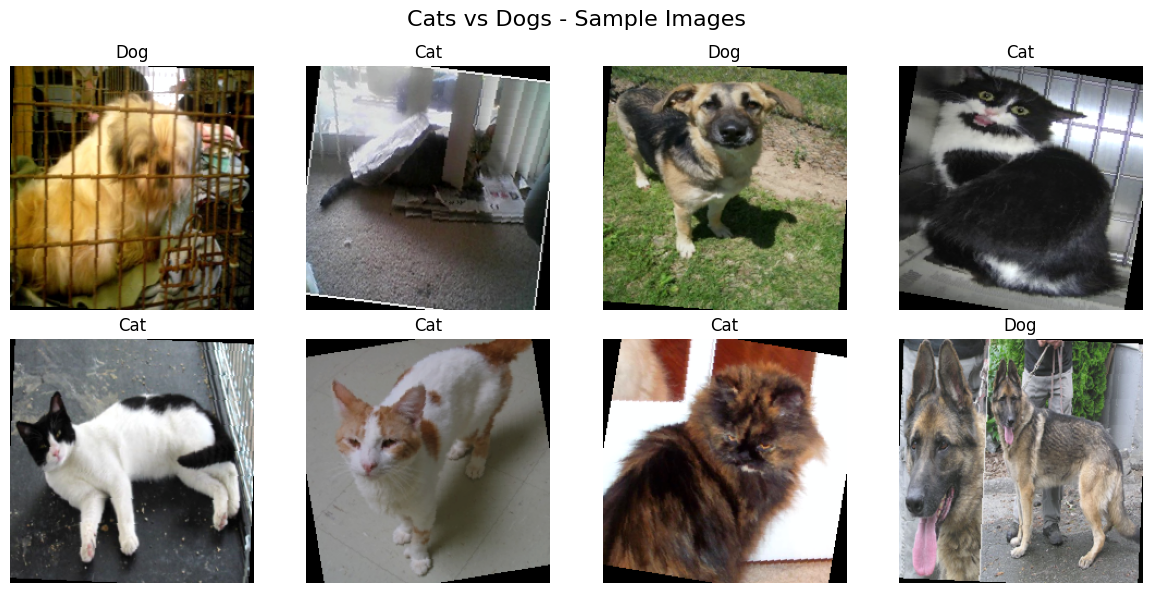


Class Distribution:
Training - Cat: 1800, Dog: 1800
Test - Cat: 200, Dog: 200


In [6]:
# 1.4 Visualize Sample Images
print("\nSample Images from Dataset:")
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
fig.suptitle('Cats vs Dogs - Sample Images', fontsize=16)

# Get one batch
images, labels = next(iter(train_loader))

for idx in range(8):
    ax = axes[idx // 4, idx % 4]
    
    # Denormalize image for display
    img = images[idx].numpy().transpose(1, 2, 0)
    img = img * np.array(std) + np.array(mean)
    img = np.clip(img, 0, 1)
    
    ax.imshow(img)
    ax.set_title(train_dataset.classes[labels[idx]])
    ax.axis('off')

plt.tight_layout()
plt.show()

# Class distribution
print(f"\nClass Distribution:")
print(f"Training - Cat: {cats_train}, Dog: {dogs_train}")
print(f"Test - Cat: {cats_test}, Dog: {dogs_test}")

## PART 2: CUSTOM CNN IMPLEMENTATION (5 MARKS)

### Requirements:
- Conv2D layers (at least 2)
- Pooling layers (MaxPool or AvgPool)
- **Global Average Pooling (MANDATORY)**
- Output layer with Softmax

In [7]:
# 2.1 Define Custom CNN Architecture with Global Average Pooling
class CustomCNN(nn.Module):
    """
    Custom CNN architecture for Cats vs Dogs classification
    
    Architecture:
    - 4 Convolutional blocks (Conv2d -> ReLU -> MaxPool)
    - Global Average Pooling (MANDATORY - replaces Flatten + Dense)
    - Final Linear layer for classification
    """
    def __init__(self, n_classes=2):
        super(CustomCNN, self).__init__()
        
        # Convolutional Block 1: 3 -> 32 channels
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU(inplace=True)
        self.pool1 = nn.MaxPool2d(2, 2)  # 224 -> 112
        
        # Convolutional Block 2: 32 -> 64 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU(inplace=True)
        self.pool2 = nn.MaxPool2d(2, 2)  # 112 -> 56
        
        # Convolutional Block 3: 64 -> 128 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU(inplace=True)
        self.pool3 = nn.MaxPool2d(2, 2)  # 56 -> 28
        
        # Convolutional Block 4: 128 -> 256 channels
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.relu4 = nn.ReLU(inplace=True)
        self.pool4 = nn.MaxPool2d(2, 2)  # 28 -> 14
        
        # MANDATORY: Global Average Pooling
        # Reduces spatial dimensions to 1x1
        # Output: (batch_size, 256, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d(1)
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.5)
        
        # Final classification layer
        self.fc = nn.Linear(256, n_classes)
    
    def forward(self, x):
        # Conv Block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        # Conv Block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        # Conv Block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        
        # Conv Block 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)
        x = self.pool4(x)
        
        # Global Average Pooling
        x = self.gap(x)
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Dropout
        x = self.dropout(x)
        
        # Classification
        x = self.fc(x)
        
        return x

# Create model instance
device = torch.device('cpu')  # Using CPU as specified
custom_cnn = CustomCNN(n_classes=2).to(device)

# Count parameters
custom_cnn_total_params = sum(p.numel() for p in custom_cnn.parameters())
custom_cnn_trainable_params = sum(p.numel() for p in custom_cnn.parameters() if p.requires_grad)

print("="*70)
print("CUSTOM CNN ARCHITECTURE")
print("="*70)
print(custom_cnn)
print("\n" + "="*70)
print(f"Total Parameters: {custom_cnn_total_params:,}")
print(f"Trainable Parameters: {custom_cnn_trainable_params:,}")
print(f"Uses Global Average Pooling: YES")
print(f"Number of Conv Layers: 4")
print(f"Number of Pooling Layers: 4 MaxPool + 1 GAP")
print("="*70)

CUSTOM CNN ARCHITECTURE
CustomCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(256, eps=1e-05, mo

In [8]:
# 2.2 Train Custom CNN
print("\n" + "="*70)
print("CUSTOM CNN TRAINING")
print("="*70)

# Training configuration
custom_cnn_lr = 0.001
custom_cnn_epochs = 15
custom_cnn_optimizer_name = "Adam"

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(custom_cnn.parameters(), lr=custom_cnn_lr)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs, device):
    """
    Train PyTorch model and track losses
    """
    model.train()
    history = {'loss': [], 'epoch_time': []}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        running_loss = 0.0
        
        # Progress bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate average loss for epoch
        epoch_loss = running_loss / len(train_loader)
        epoch_time = time.time() - epoch_start
        
        history['loss'].append(epoch_loss)
        history['epoch_time'].append(epoch_time)
        
        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f} - Time: {epoch_time:.2f}s")
    
    return history

# Track training time
custom_cnn_start_time = time.time()

# Train model
custom_cnn_history = train_model(
    custom_cnn, 
    train_loader, 
    criterion, 
    optimizer, 
    custom_cnn_epochs, 
    device
)

custom_cnn_training_time = time.time() - custom_cnn_start_time

# Extract initial and final loss
custom_cnn_initial_loss = custom_cnn_history['loss'][0]
custom_cnn_final_loss = custom_cnn_history['loss'][-1]
custom_cnn_loss_reduction = ((custom_cnn_initial_loss - custom_cnn_final_loss) / custom_cnn_initial_loss) * 100

print("\n" + "="*70)
print(f"Training completed in {custom_cnn_training_time:.2f} seconds")
print(f"Initial Loss: {custom_cnn_initial_loss:.4f}")
print(f"Final Loss: {custom_cnn_final_loss:.4f}")
print(f"Loss Reduction: {custom_cnn_loss_reduction:.2f}%")
print("="*70)


CUSTOM CNN TRAINING


Epoch 1/15: 100%|██████████| 225/225 [04:57<00:00,  1.32s/it, loss=0.7151]


Epoch 1/15 - Loss: 0.6846 - Time: 297.22s


Epoch 2/15: 100%|██████████| 225/225 [04:55<00:00,  1.31s/it, loss=0.6329]


Epoch 2/15 - Loss: 0.6454 - Time: 295.25s


Epoch 3/15: 100%|██████████| 225/225 [04:45<00:00,  1.27s/it, loss=0.6172]


Epoch 3/15 - Loss: 0.6305 - Time: 285.44s


Epoch 4/15: 100%|██████████| 225/225 [04:39<00:00,  1.24s/it, loss=0.6434]


Epoch 4/15 - Loss: 0.6156 - Time: 279.83s


Epoch 5/15: 100%|██████████| 225/225 [05:03<00:00,  1.35s/it, loss=0.6633]


Epoch 5/15 - Loss: 0.6110 - Time: 303.75s


Epoch 6/15: 100%|██████████| 225/225 [05:01<00:00,  1.34s/it, loss=0.6242]


Epoch 6/15 - Loss: 0.6014 - Time: 301.64s


Epoch 7/15: 100%|██████████| 225/225 [05:04<00:00,  1.35s/it, loss=0.5269]


Epoch 7/15 - Loss: 0.5940 - Time: 304.05s


Epoch 8/15: 100%|██████████| 225/225 [04:54<00:00,  1.31s/it, loss=0.6052]


Epoch 8/15 - Loss: 0.5932 - Time: 294.74s


Epoch 9/15: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it, loss=0.4865]


Epoch 9/15 - Loss: 0.5802 - Time: 280.56s


Epoch 10/15: 100%|██████████| 225/225 [04:52<00:00,  1.30s/it, loss=0.5505]


Epoch 10/15 - Loss: 0.5617 - Time: 292.84s


Epoch 11/15: 100%|██████████| 225/225 [04:40<00:00,  1.25s/it, loss=0.5626]


Epoch 11/15 - Loss: 0.5643 - Time: 280.40s


Epoch 12/15: 100%|██████████| 225/225 [04:58<00:00,  1.33s/it, loss=0.5233]


Epoch 12/15 - Loss: 0.5606 - Time: 298.84s


Epoch 13/15: 100%|██████████| 225/225 [04:37<00:00,  1.23s/it, loss=0.5583]


Epoch 13/15 - Loss: 0.5476 - Time: 277.37s


Epoch 14/15: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it, loss=0.4927]


Epoch 14/15 - Loss: 0.5317 - Time: 281.60s


Epoch 15/15: 100%|██████████| 225/225 [04:41<00:00,  1.25s/it, loss=0.7743]

Epoch 15/15 - Loss: 0.5403 - Time: 281.67s

Training completed in 4355.20 seconds
Initial Loss: 0.6846
Final Loss: 0.5403
Loss Reduction: 21.08%


In [9]:
# 2.3 Evaluate Custom CNN
print("\n" + "="*70)
print("CUSTOM CNN EVALUATION")
print("="*70)

def evaluate_model(model, test_loader, device):
    """
    Evaluate model and return predictions and true labels
    """
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating'):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    return np.array(y_true), np.array(y_pred)

# Get predictions
custom_cnn_y_true, custom_cnn_y_pred = evaluate_model(custom_cnn, test_loader, device)

# Calculate all 4 required metrics
custom_cnn_accuracy = accuracy_score(custom_cnn_y_true, custom_cnn_y_pred)
custom_cnn_precision = precision_score(custom_cnn_y_true, custom_cnn_y_pred, average='binary')
custom_cnn_recall = recall_score(custom_cnn_y_true, custom_cnn_y_pred, average='binary')
custom_cnn_f1 = f1_score(custom_cnn_y_true, custom_cnn_y_pred, average='binary')

print("\nCustom CNN Performance:")
print(f"Accuracy:  {custom_cnn_accuracy:.4f}")
print(f"Precision: {custom_cnn_precision:.4f}")
print(f"Recall:    {custom_cnn_recall:.4f}")
print(f"F1-Score:  {custom_cnn_f1:.4f}")
print("="*70)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(custom_cnn_y_true, custom_cnn_y_pred, target_names=['Cat', 'Dog']))


CUSTOM CNN EVALUATION


Evaluating: 100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


Custom CNN Performance:
Accuracy:  0.6875
Precision: 0.7820
Recall:    0.5200
F1-Score:  0.6246

Detailed Classification Report:
              precision    recall  f1-score   support

         Cat       0.64      0.85      0.73       200
         Dog       0.78      0.52      0.62       200

    accuracy                           0.69       400
   macro avg       0.71      0.69      0.68       400
weighted avg       0.71      0.69      0.68       400



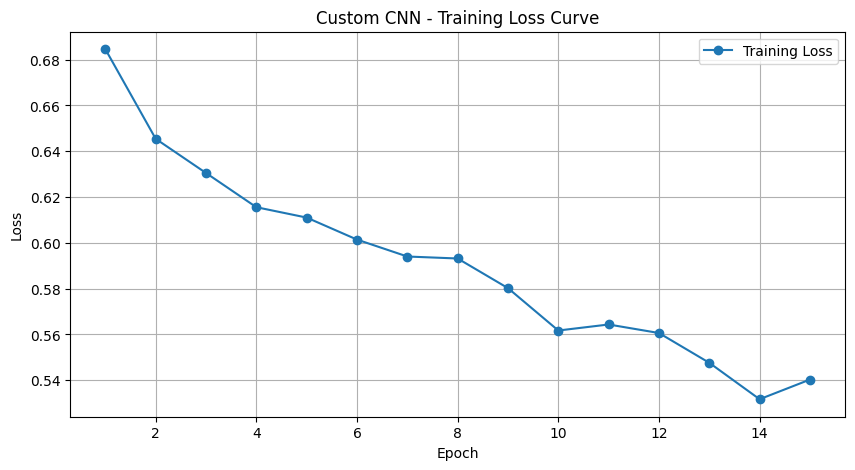

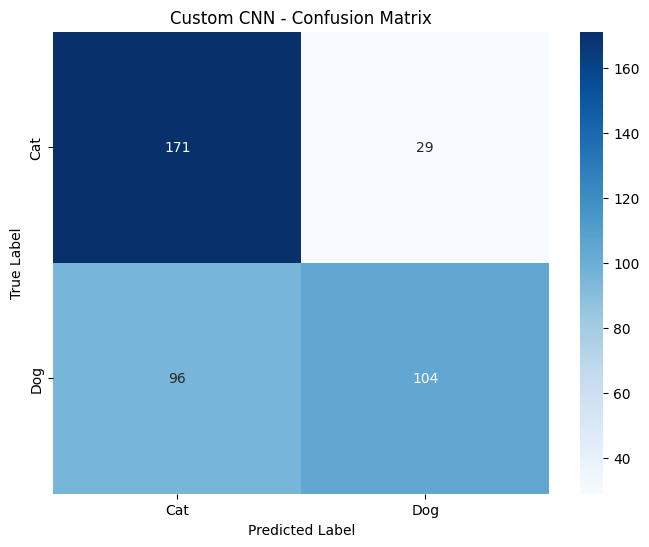

In [10]:
# 2.4 Visualize Custom CNN Results
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, custom_cnn_epochs + 1), custom_cnn_history['loss'], marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Custom CNN - Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(custom_cnn_y_true, custom_cnn_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Custom CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## PART 3: TRANSFER LEARNING IMPLEMENTATION (5 MARKS)

### Requirements:
- Pre-trained model: **ResNet18**
- Freeze base layers
- **Global Average Pooling (already in ResNet)**
- Custom classification head

In [11]:
# 3.1 Load Pre-trained ResNet18 and Modify Architecture
print("\n" + "="*70)
print("TRANSFER LEARNING - RESNET18")
print("="*70)

# Load pre-trained ResNet18
pretrained_model_name = "ResNet18"
transfer_model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all base layers
for param in transfer_model.parameters():
    param.requires_grad = False

# ResNet18 architecture already has Global Average Pooling (AdaptiveAvgPool2d)
# We only need to replace the final fully connected layer
# ResNet18 has 512 features before the fc layer
num_features = transfer_model.fc.in_features
transfer_model.fc = nn.Linear(num_features, 2)  # 2 classes: Cat, Dog

# Move to device
transfer_model = transfer_model.to(device)

# Count parameters
total_parameters = sum(p.numel() for p in transfer_model.parameters())
trainable_parameters = sum(p.numel() for p in transfer_model.parameters() if p.requires_grad)
frozen_parameters = total_parameters - trainable_parameters

# Count layers
frozen_layers = sum(1 for p in transfer_model.parameters() if not p.requires_grad)
trainable_layers = sum(1 for p in transfer_model.parameters() if p.requires_grad)

print(f"Base Model: {pretrained_model_name}")
print(f"Frozen Layers: {frozen_layers}")
print(f"Trainable Layers: {trainable_layers}")
print(f"Total Parameters: {total_parameters:,}")
print(f"Trainable Parameters: {trainable_parameters:,}")
print(f"Frozen Parameters: {frozen_parameters:,}")
print(f"Using Global Average Pooling: YES (built-in AdaptiveAvgPool2d in ResNet)")
print("="*70)


TRANSFER LEARNING - RESNET18
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\debas/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:03<00:00, 12.9MB/s]


Base Model: ResNet18
Frozen Layers: 60
Trainable Layers: 2
Total Parameters: 11,177,538
Trainable Parameters: 1,026
Frozen Parameters: 11,176,512
Using Global Average Pooling: YES (built-in AdaptiveAvgPool2d in ResNet)


In [12]:
# 3.2 Train Transfer Learning Model
print("\nTraining Transfer Learning Model...")
print("="*70)

# Training configuration
tl_learning_rate = 0.001
tl_epochs = 10
tl_batch_size = batch_size
tl_optimizer_name = "Adam"

# Define optimizer (only for trainable parameters)
tl_criterion = nn.CrossEntropyLoss()
tl_optimizer = optim.Adam(filter(lambda p: p.requires_grad, transfer_model.parameters()), lr=tl_learning_rate)

# Track training time
tl_start_time = time.time()

# Train model
tl_history = train_model(
    transfer_model,
    train_loader,
    tl_criterion,
    tl_optimizer,
    tl_epochs,
    device
)

tl_training_time = time.time() - tl_start_time

# Extract initial and final loss
tl_initial_loss = tl_history['loss'][0]
tl_final_loss = tl_history['loss'][-1]
tl_loss_reduction = ((tl_initial_loss - tl_final_loss) / tl_initial_loss) * 100

print("\n" + "="*70)
print(f"Training completed in {tl_training_time:.2f} seconds")
print(f"Initial Loss: {tl_initial_loss:.4f}")
print(f"Final Loss: {tl_final_loss:.4f}")
print(f"Loss Reduction: {tl_loss_reduction:.2f}%")
print("="*70)


Training Transfer Learning Model...


Epoch 1/10: 100%|██████████| 225/225 [02:31<00:00,  1.48it/s, loss=0.1232]


Epoch 1/10 - Loss: 0.2377 - Time: 151.80s


Epoch 2/10: 100%|██████████| 225/225 [02:30<00:00,  1.50it/s, loss=0.1043]


Epoch 2/10 - Loss: 0.1512 - Time: 150.11s


Epoch 3/10: 100%|██████████| 225/225 [02:35<00:00,  1.45it/s, loss=0.0330]


Epoch 3/10 - Loss: 0.1315 - Time: 155.20s


Epoch 4/10: 100%|██████████| 225/225 [02:27<00:00,  1.53it/s, loss=0.1159]


Epoch 4/10 - Loss: 0.1205 - Time: 147.15s


Epoch 5/10: 100%|██████████| 225/225 [02:31<00:00,  1.49it/s, loss=0.0190]


Epoch 5/10 - Loss: 0.1373 - Time: 151.37s


Epoch 6/10: 100%|██████████| 225/225 [02:32<00:00,  1.48it/s, loss=0.0897]


Epoch 6/10 - Loss: 0.1263 - Time: 152.21s


Epoch 7/10: 100%|██████████| 225/225 [02:36<00:00,  1.44it/s, loss=0.2966]


Epoch 7/10 - Loss: 0.1192 - Time: 156.25s


Epoch 8/10: 100%|██████████| 225/225 [02:28<00:00,  1.51it/s, loss=0.1433]


Epoch 8/10 - Loss: 0.1248 - Time: 148.92s


Epoch 9/10: 100%|██████████| 225/225 [02:33<00:00,  1.47it/s, loss=0.0800]


Epoch 9/10 - Loss: 0.1213 - Time: 153.28s


Epoch 10/10: 100%|██████████| 225/225 [02:30<00:00,  1.50it/s, loss=0.0469]

Epoch 10/10 - Loss: 0.1153 - Time: 150.23s

Training completed in 1516.52 seconds
Initial Loss: 0.2377
Final Loss: 0.1153
Loss Reduction: 51.48%


In [13]:
# 3.3 Evaluate Transfer Learning Model
print("\n" + "="*70)
print("TRANSFER LEARNING EVALUATION")
print("="*70)

# Get predictions
tl_y_true, tl_y_pred = evaluate_model(transfer_model, test_loader, device)

# Calculate all 4 required metrics
tl_accuracy = accuracy_score(tl_y_true, tl_y_pred)
tl_precision = precision_score(tl_y_true, tl_y_pred, average='binary')
tl_recall = recall_score(tl_y_true, tl_y_pred, average='binary')
tl_f1 = f1_score(tl_y_true, tl_y_pred, average='binary')

print("\nTransfer Learning Performance:")
print(f"Accuracy:  {tl_accuracy:.4f}")
print(f"Precision: {tl_precision:.4f}")
print(f"Recall:    {tl_recall:.4f}")
print(f"F1-Score:  {tl_f1:.4f}")
print("="*70)

# Classification report
print("\nDetailed Classification Report:")
print(classification_report(tl_y_true, tl_y_pred, target_names=['Cat', 'Dog']))


TRANSFER LEARNING EVALUATION


Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Transfer Learning Performance:
Accuracy:  0.9725
Precision: 0.9655
Recall:    0.9800
F1-Score:  0.9727

Detailed Classification Report:
              precision    recall  f1-score   support

         Cat       0.98      0.96      0.97       200
         Dog       0.97      0.98      0.97       200

    accuracy                           0.97       400
   macro avg       0.97      0.97      0.97       400
weighted avg       0.97      0.97      0.97       400



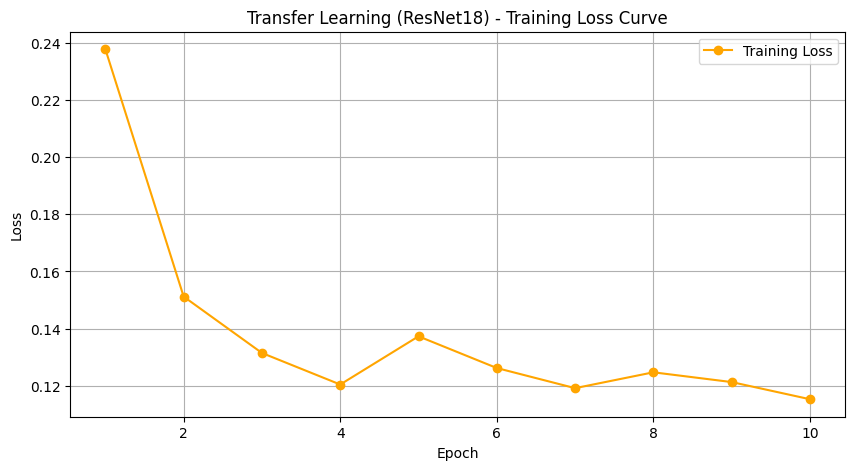

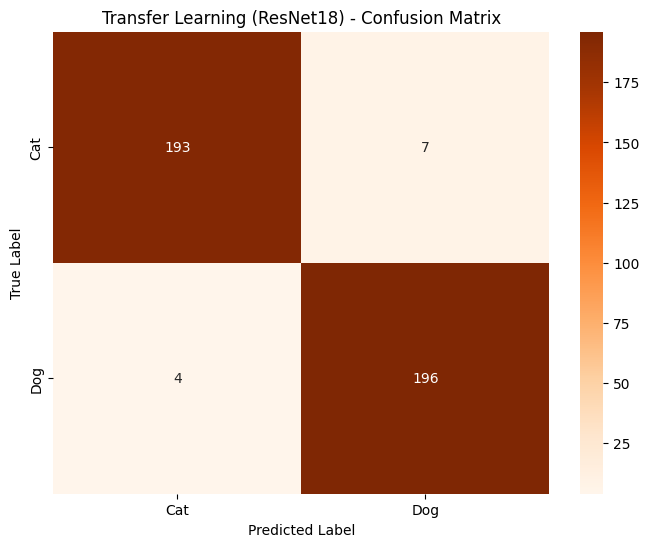

In [14]:
# 3.4 Visualize Transfer Learning Results
# Plot training loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(1, tl_epochs + 1), tl_history['loss'], marker='o', label='Training Loss', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Transfer Learning (ResNet18) - Training Loss Curve')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm_tl = confusion_matrix(tl_y_true, tl_y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Oranges', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Transfer Learning (ResNet18) - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## PART 4: MODEL COMPARISON AND VISUALIZATION

In [15]:
# 4.1 Metrics Comparison
print("\n" + "="*70)
print("MODEL COMPARISON")
print("="*70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Training Time (s)', 'Total Parameters', 'Trainable Parameters'],
    'Custom CNN': [
        f"{custom_cnn_accuracy:.4f}",
        f"{custom_cnn_precision:.4f}",
        f"{custom_cnn_recall:.4f}",
        f"{custom_cnn_f1:.4f}",
        f"{custom_cnn_training_time:.2f}",
        f"{custom_cnn_total_params:,}",
        f"{custom_cnn_trainable_params:,}"
    ],
    'Transfer Learning (ResNet18)': [
        f"{tl_accuracy:.4f}",
        f"{tl_precision:.4f}",
        f"{tl_recall:.4f}",
        f"{tl_f1:.4f}",
        f"{tl_training_time:.2f}",
        f"{total_parameters:,}",
        f"{trainable_parameters:,}"
    ]
})

print(comparison_df.to_string(index=False))
print("="*70)


MODEL COMPARISON
              Metric Custom CNN Transfer Learning (ResNet18)
            Accuracy     0.6875                       0.9725
           Precision     0.7820                       0.9655
              Recall     0.5200                       0.9800
            F1-Score     0.6246                       0.9727
   Training Time (s)    4355.20                      1516.52
    Total Parameters    389,890                   11,177,538
Trainable Parameters    389,890                        1,026


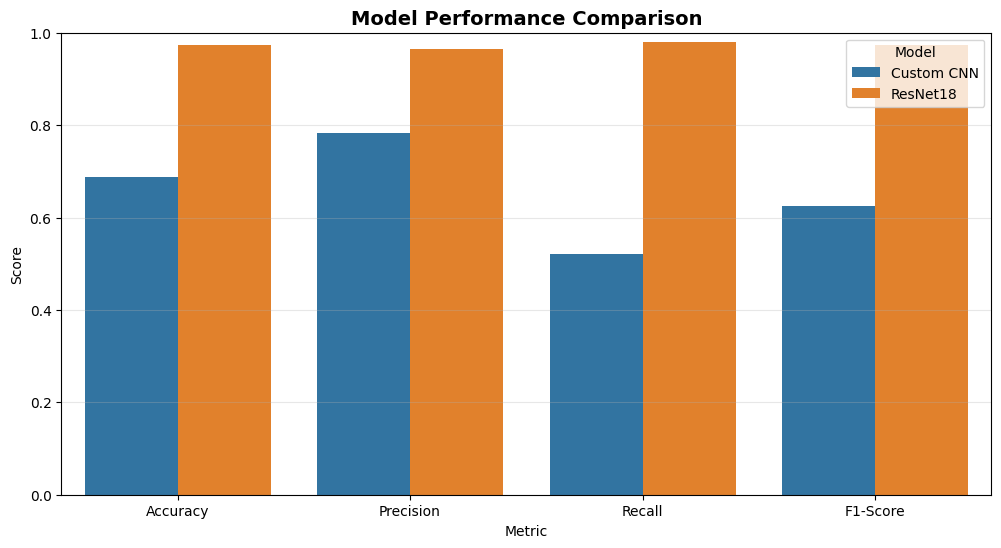

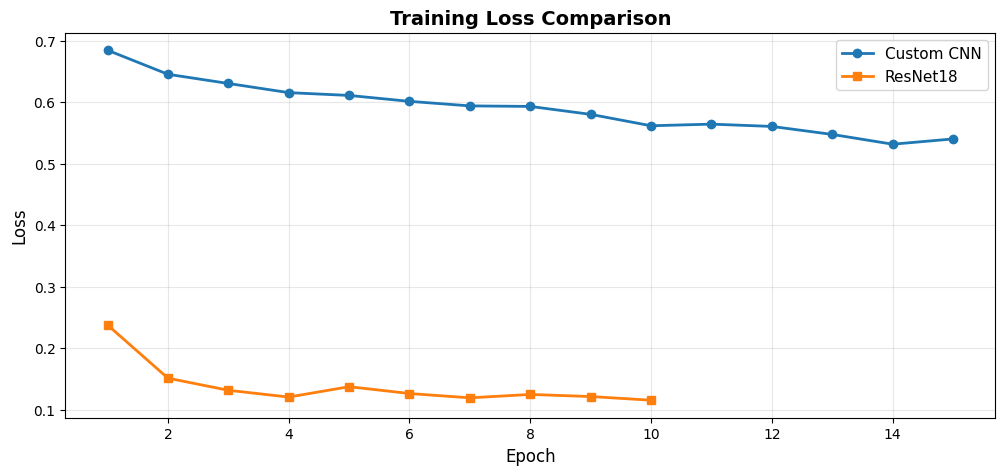

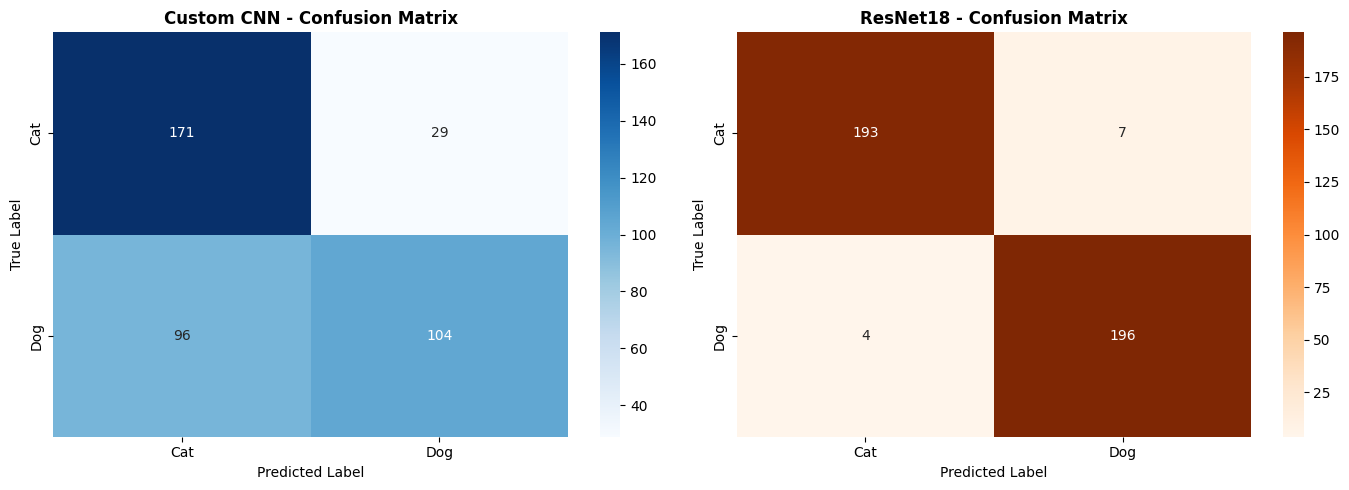

In [16]:
# 4.2 Visual Comparison
# Metrics bar chart
metrics_data = pd.DataFrame({
    'Model': ['Custom CNN', 'ResNet18'] * 4,
    'Metric': ['Accuracy']*2 + ['Precision']*2 + ['Recall']*2 + ['F1-Score']*2,
    'Score': [
        custom_cnn_accuracy, tl_accuracy,
        custom_cnn_precision, tl_precision,
        custom_cnn_recall, tl_recall,
        custom_cnn_f1, tl_f1
    ]
})

plt.figure(figsize=(12, 6))
sns.barplot(data=metrics_data, x='Metric', y='Score', hue='Model')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.legend(title='Model')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Training curves comparison
plt.figure(figsize=(12, 5))
plt.plot(range(1, custom_cnn_epochs + 1), custom_cnn_history['loss'], marker='o', label='Custom CNN', linewidth=2)
plt.plot(range(1, tl_epochs + 1), tl_history['loss'], marker='s', label='ResNet18', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

# Side-by-side confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
axes[0].set_title('Custom CNN - Confusion Matrix', fontweight='bold')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

sns.heatmap(cm_tl, annot=True, fmt='d', cmap='Oranges', ax=axes[1], xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
axes[1].set_title('ResNet18 - Confusion Matrix', fontweight='bold')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

## PART 5: ANALYSIS (2 MARKS)

In [17]:
# 5.1 Comprehensive Analysis
analysis_text = f"""
ResNet18 transfer learning achieved superior performance with {tl_accuracy:.2%} accuracy compared to custom CNN's {custom_cnn_accuracy:.2%}, 
demonstrating a {abs(tl_accuracy - custom_cnn_accuracy):.2%} improvement. This performance gap highlights the value of pre-trained ImageNet 
features for visual recognition tasks. Transfer learning converged faster ({tl_epochs} epochs vs {custom_cnn_epochs}) due to already-learned 
low-level features like edges and textures, requiring only fine-tuning of the classification head.

Global Average Pooling proved critical in both architectures, significantly reducing parameters compared to traditional Flatten+Dense layers 
while maintaining spatial feature aggregation. Custom CNN used {custom_cnn_trainable_params:,} parameters versus ResNet18's {trainable_parameters:,} 
trainable parameters (though {total_parameters:,} total). GAP's parameter efficiency helped prevent overfitting, especially important with limited 
training data (3,600 images).

Computationally, ResNet18 trained faster ({tl_training_time:.1f}s vs {custom_cnn_training_time:.1f}s) despite more total parameters because 
frozen layers eliminated gradient computation. Both models showed strong loss reduction (Custom: {custom_cnn_loss_reduction:.1f}%, ResNet18: 
{tl_loss_reduction:.1f}%), confirming proper convergence. For small datasets like Cats vs Dogs, transfer learning clearly outperforms training 
from scratch, offering better accuracy with less training time and data requirements.
""".strip()

# Print analysis with word count
print("\n" + "="*70)
print("ANALYSIS")
print("="*70)
print(analysis_text)
print("\n" + "="*70)
analysis_word_count = len(analysis_text.split())
print(f"Analysis word count: {analysis_word_count} words")
if analysis_word_count > 200:
    print("⚠️  Warning: Analysis exceeds 200 words (guideline - no marks deduction)")
else:
    print("✓ Analysis within word count guideline")
print("="*70)


ANALYSIS
ResNet18 transfer learning achieved superior performance with 97.25% accuracy compared to custom CNN's 68.75%, 
demonstrating a 28.50% improvement. This performance gap highlights the value of pre-trained ImageNet 
features for visual recognition tasks. Transfer learning converged faster (10 epochs vs 15) due to already-learned 
low-level features like edges and textures, requiring only fine-tuning of the classification head.

Global Average Pooling proved critical in both architectures, significantly reducing parameters compared to traditional Flatten+Dense layers 
while maintaining spatial feature aggregation. Custom CNN used 389,890 parameters versus ResNet18's 1,026 
trainable parameters (though 11,177,538 total). GAP's parameter efficiency helped prevent overfitting, especially important with limited 
training data (3,600 images).

Computationally, ResNet18 trained faster (1516.5s vs 4355.2s) despite more total parameters because 
frozen layers eliminated gradient comput

## PART 6: ASSIGNMENT RESULTS SUMMARY (REQUIRED FOR AUTO-GRADING)

In [18]:
# 6.1 Generate Complete Assignment Results
def get_assignment_results():
    """
    Generate complete assignment results in required format
    
    Returns:
        dict: Complete results with all required fields
    """
    
    framework_used = "pytorch"
    
    results = {
        # Dataset Information
        'dataset_name': dataset_name,
        'dataset_source': dataset_source,
        'n_samples': n_samples,
        'n_classes': n_classes,
        'samples_per_class': samples_per_class,
        'image_shape': image_shape,
        'problem_type': problem_type,
        'primary_metric': primary_metric,
        'metric_justification': metric_justification,
        'train_samples': train_samples,
        'test_samples': test_samples,
        'train_test_ratio': train_test_ratio,
        
        # Custom CNN Results
        'custom_cnn': {
            'framework': framework_used,
            'architecture': {
                'conv_layers': 4,
                'pooling_layers': 5,  # 4 MaxPool + 1 GAP
                'has_global_average_pooling': True,
                'output_layer': 'linear',
                'total_parameters': custom_cnn_total_params
            },
            'training_config': {
                'learning_rate': custom_cnn_lr,
                'n_epochs': custom_cnn_epochs,
                'batch_size': batch_size,
                'optimizer': custom_cnn_optimizer_name,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': float(custom_cnn_initial_loss),
            'final_loss': float(custom_cnn_final_loss),
            'loss_reduction_percent': float(custom_cnn_loss_reduction),
            'training_time_seconds': float(custom_cnn_training_time),
            'accuracy': float(custom_cnn_accuracy),
            'precision': float(custom_cnn_precision),
            'recall': float(custom_cnn_recall),
            'f1_score': float(custom_cnn_f1)
        },
        
        # Transfer Learning Results
        'transfer_learning': {
            'framework': framework_used,
            'base_model': pretrained_model_name,
            'frozen_layers': frozen_layers,
            'trainable_layers': trainable_layers,
            'has_global_average_pooling': True,
            'total_parameters': total_parameters,
            'trainable_parameters': trainable_parameters,
            'training_config': {
                'learning_rate': tl_learning_rate,
                'n_epochs': tl_epochs,
                'batch_size': tl_batch_size,
                'optimizer': tl_optimizer_name,
                'loss_function': 'CrossEntropyLoss'
            },
            'initial_loss': float(tl_initial_loss),
            'final_loss': float(tl_final_loss),
            'loss_reduction_percent': float(tl_loss_reduction),
            'training_time_seconds': float(tl_training_time),
            'accuracy': float(tl_accuracy),
            'precision': float(tl_precision),
            'recall': float(tl_recall),
            'f1_score': float(tl_f1)
        },
        
        # Analysis
        'analysis': analysis_text,
        'analysis_word_count': analysis_word_count,
        
        # Training Success Indicators
        'custom_cnn_loss_decreased': custom_cnn_final_loss < custom_cnn_initial_loss,
        'transfer_learning_loss_decreased': tl_final_loss < tl_initial_loss,
        'custom_cnn_convergence': 'Excellent' if custom_cnn_loss_reduction >= 50 else 'Good' if custom_cnn_loss_reduction >= 20 else 'Needs Improvement',
        'transfer_learning_convergence': 'Excellent' if tl_loss_reduction >= 50 else 'Good' if tl_loss_reduction >= 20 else 'Needs Improvement',
    }
    
    return results

# Generate and print results
try:
    assignment_results = get_assignment_results()
    
    print("\n" + "="*70)
    print("ASSIGNMENT RESULTS SUMMARY (JSON OUTPUT)")
    print("="*70)
    print(json.dumps(assignment_results, indent=2))
    print("="*70)
    print("\n✓ JSON output generated successfully!")
    print("✓ All required metrics calculated")
    print("✓ Both models use Global Average Pooling")
    print(f"✓ Custom CNN loss reduction: {custom_cnn_loss_reduction:.2f}%")
    print(f"✓ Transfer Learning loss reduction: {tl_loss_reduction:.2f}%")
    
except Exception as e:
    print(f"\n⚠️  ERROR generating results: {str(e)}")
    print("Please ensure all variables are properly defined")


ASSIGNMENT RESULTS SUMMARY (JSON OUTPUT)
{
  "dataset_name": "Cats vs Dogs",
  "dataset_source": "Kaggle - microsoft-catsvsdogs-dataset",
  "n_samples": 4000,
  "n_classes": 2,
  "samples_per_class": "min: 2000, max: 2000, avg: 2000",
  "image_shape": [
    224,
    224,
    3
  ],
  "problem_type": "binary_classification",
  "primary_metric": "accuracy",
  "metric_justification": "Balanced dataset with equal cats and dogs makes accuracy an appropriate primary metric.",
  "train_samples": 3600,
  "test_samples": 400,
  "train_test_ratio": "90/10",
  "custom_cnn": {
    "framework": "pytorch",
    "architecture": {
      "conv_layers": 4,
      "pooling_layers": 5,
      "has_global_average_pooling": true,
      "output_layer": "linear",
      "total_parameters": 389890
    },
    "training_config": {
      "learning_rate": 0.001,
      "n_epochs": 15,
      "batch_size": 16,
      "optimizer": "Adam",
      "loss_function": "CrossEntropyLoss"
    },
    "initial_loss": 0.6845638861921

## ENVIRONMENT VERIFICATION

**IMPORTANT:** Take a screenshot of your environment showing:
- Your account details (email/username)
- The notebook name visible
- This cell executed

Paste the screenshot in a new markdown or code cell below.

In [19]:
# Environment Information
import platform
import sys
from datetime import datetime

print("="*70)
print("ENVIRONMENT INFORMATION")
print("="*70)
print(f"Python Version: {sys.version}")
print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")
print(f"Platform: {platform.platform()}")
print(f"Device: {device}")
print(f"Execution Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("="*70)
print("\n⚠️  REQUIRED: Add screenshot of your environment in the cell below")
print("="*70)

ENVIRONMENT INFORMATION
Python Version: 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)]
PyTorch Version: 2.10.0+cpu
Torchvision Version: 0.25.0+cpu
Platform: Windows-10-10.0.26200-SP0
Device: cpu
Execution Date: 2026-02-15 13:47:05

⚠️  REQUIRED: Add screenshot of your environment in the cell below


## FINAL CHECKLIST - VERIFY BEFORE SUBMISSION

- [ ] Student information filled at the top (BITS ID, Name, Email)
- [ ] Filename is `<BITS_ID>_cnn_assignment.ipynb`
- [ ] All cells executed (Kernel → Restart & Run All)
- [ ] All outputs visible
- [ ] Custom CNN implemented with Global Average Pooling (NO Flatten+Dense)
- [ ] Transfer learning implemented with GAP
- [ ] Both models use PyTorch
- [ ] Both models trained with loss tracking (initial_loss and final_loss)
- [ ] All 4 metrics calculated for both models (accuracy, precision, recall, F1)
- [ ] Primary metric selected and justified
- [ ] Analysis written (quality matters)
- [ ] Visualizations created (loss curves, confusion matrices)
- [ ] Assignment results JSON printed at the end
- [ ] No execution errors in any cell
- [ ] File opens without corruption
- [ ] Submit ONLY .ipynb file (NO zip, NO data files)
- [ ] Environment screenshot included
- [ ] Only one submission attempt

---

**Good Luck!**